# test the bridge code by computing some statistics

testing the binomial bridge


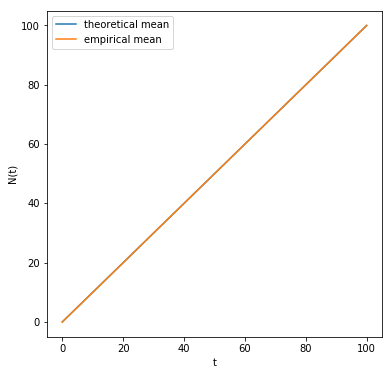

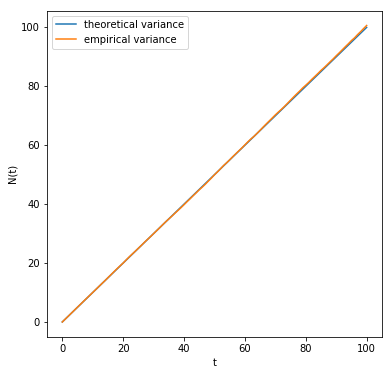

mean of interarrival times: 0.9999187035553814
variance interarrival times: 0.9995989298183101
(slope, intercept, r): (0.9998018311642837, 0.00011719212628558129, 0.9999992604312179)


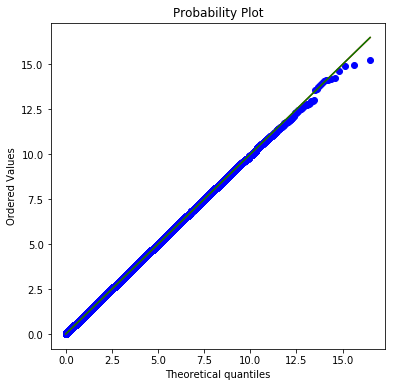


-------------------------------------------

testing the beta bridge


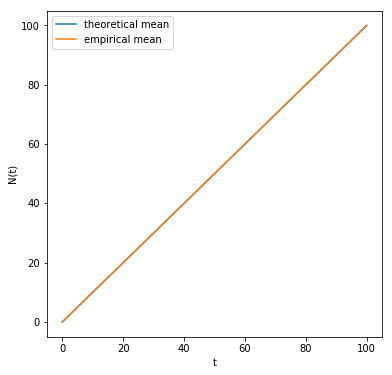

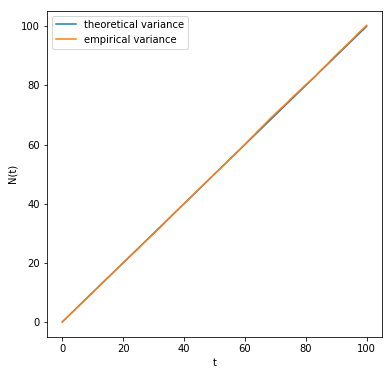

mean of interarrival times: 1.000055227558393
variance interarrival times: 1.0004844913489463
(slope, intercept, r): (1.0002437746273836, -0.00018822415895680678, 0.9999984034779431)


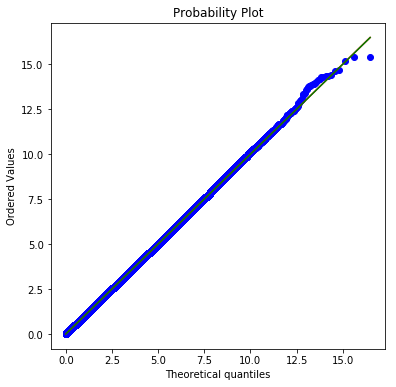

In [2]:
%matplotlib inline

from binomial_bridge import BinomialBridge
from beta_bridge import BetaBridge

import numpy as np
import scipy
import sobol_seq
import matplotlib.pyplot as plt

#jump_times_list is a list of jump time paths, where each element corresponds to a path
def plot_jump_times_stats(jump_times_list, T, is_beta_bridge):
    times_interp = np.linspace(0, T, 100+1)

    if is_beta_bridge:
        #need to create a different set of jump times, otherwise the interarrival times become biased
        #by filling in the rest of the jump times between jump_times[-1] and T
        #however, by doing so we get the right mean and expectation of the counting process
        jump_times_interp = []
        for jump_times in jump_times_list:
            if jump_times[-1] >= T:
                jump_times_interp.append(jump_times)
            else:
                dt = T - jump_times[-1]
                y = np.random.poisson(dt)
                if y > 0:
                    new_times = jump_times[-1] + np.sort(np.random.uniform(0, dt, size=y))
                    jump_times_interp.append(np.concatenate((jump_times, new_times)))
                else:
                    jump_times_interp.append(jump_times)
    else:
        jump_times_interp = jump_times_list
        
    counts = [range(1, len(jump_times)+1) for jump_times in jump_times_interp]  
    
    interp_functions = [scipy.interpolate.interp1d(jump_times, count, kind='previous', fill_value=(0, count[-1]), bounds_error=False)
                        if jump_times.size > 1 else lambda x: np.zeros(x.size) for jump_times,count in zip(jump_times_interp, counts)]

    interp_counts = [func(times_interp) for func in interp_functions]
    interp_counts = np.vstack(interp_counts)

    plt.figure(figsize=(6,6))
    plt.plot(times_interp, times_interp, label='theoretical mean')
    plt.plot(times_interp, np.mean(interp_counts, axis=0), label='empirical mean')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('N(t)')
    plt.show()

    plt.figure(figsize=(6,6))
    plt.plot(times_interp, times_interp, label='theoretical variance')
    plt.plot(times_interp, np.var(interp_counts, axis=0), label='empirical variance')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('N(t)')
    plt.show()

    plt.figure(figsize=(6,6))
    interarrival_times = [np.diff(jump_times, prepend=0) for jump_times in jump_times_list]
    interarrival_times = np.concatenate(interarrival_times)
    
    print('mean of interarrival times: {}'.format(np.mean(interarrival_times)))
    print('variance interarrival times: {}'.format(np.var(interarrival_times)))
    
    quantiles, line = scipy.stats.probplot(interarrival_times, dist='expon', plot=plt)
    print('(slope, intercept, r): {}'.format(line))
    x = np.linspace(0, quantiles[0][-1], 101)
    plt.plot(x,x, color='green')
    plt.show()

################################
# parameters for the tests
################################
n = 1*10**5
discretization_power = 4
dim = 2**discretization_power
    
T = Y_at_T = 100

# points = sobol_seq.i4_sobol_generate(dim, n).T

points = np.random.uniform(size=(dim, n))

################################
# test the binomial bridge
################################
print('testing the binomial bridge')
binom_bridge = BinomialBridge(T, discretization_power, points)
binom_bridge.generate()
binom_bridge.fill_jump_times()

plot_jump_times_stats(binom_bridge.jump_times, T, False)

print('\n-------------------------------------------\n')

# ################################
# # test the beta bridge
# ################################
print('testing the beta bridge')
beta_bridge = BetaBridge(Y_at_T, discretization_power, points)
beta_bridge.generate()
beta_bridge.fill_jump_times()

plot_jump_times_stats(beta_bridge.jump_times, Y_at_T, True)

# example of how to use a Poisson bridge with quasi-random points and a stochastic reaction network model


                   A
count  100000.000000
mean       56.774940
std         7.429507
min        25.000000
25%        52.000000
50%        57.000000
75%        62.000000
max        91.000000

mean number of jumps: [ 99.99327 143.21833]



                   A
count  100000.000000
mean       56.771070
std         7.408982
min        24.000000
25%        52.000000
50%        57.000000
75%        62.000000
max        91.000000




                   A
count  100000.000000
mean       56.745590
std         7.410233
min        27.000000
25%        52.000000
50%        57.000000
75%        62.000000
max        88.000000



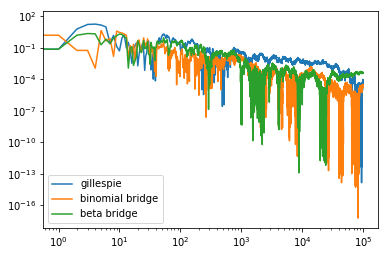

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from tqdm import tnrange, tqdm_notebook

from binomial_bridge import BinomialBridge
from beta_bridge import BetaBridge

import numpy as np
import sobol_seq
import matplotlib.pyplot as plt

from model_data import ModelData
from birth_death_model import BirthDeathModel
from birth_model import BirthModel
from dimerization_model import DimerizationModel

from nrm_with_bridge import nrm_with_bridge
from gillespie import gillespie

import pandas as pd

model_data = ModelData(BirthDeathModel(),
                       ['A'],
                       2,
                       'Birth-Death')
x0 = np.array([100])
expected_values = np.array([56.766764161831])

# model_data = ModelData(BirthModel(),
#                        ['A'],
#                        2.,
#                        'Birth')
# x0 = np.array([10])
# expected_values = np.array([x0[0] * np.exp(model_data.t)])

# model_data = ModelData(DimerizationModel(),
#                        ['mRNA', 'protein', 'dimer'],
#                        1.5,
#                        'Dimerization')
# x0 = np.array([0, 0, 0])

test_n = 10**5
n = 10**5

all_paths_states = np.zeros((test_n, len(x0)), dtype=int)
all_paths_num_jumps = np.zeros((test_n, model_data.model.R), dtype=int)
for i in tnrange(test_n, desc='Running test simulations'):
    _, state_path, num_jumps = gillespie(model_data.model, x0, model_data.t)
    all_paths_states[i,:] = state_path[-1,:]
    all_paths_num_jumps[i,:] = num_jumps
    
gillespie_df = pd.DataFrame(all_paths_states, columns=model_data.species)
print(gillespie_df.describe())
print()

mean_jumps = np.mean(all_paths_num_jumps, axis=0)
print('mean number of jumps: {}'.format(mean_jumps))

# ##############################

discretization_power = 3
dim = 2**discretization_power

points = sobol_seq.i4_sobol_generate(dim * model_data.model.R, n).T

# #####################################

bridges = [BinomialBridge(T, discretization_power, points[i::model_data.model.R,:]) for i,T in enumerate(mean_jumps)]
# bridges = [BinomialBridge(T, discretization_power, np.random.uniform(size=(dim, n))) for T in mean_jumps]

for bridge in bridges:
    bridge.generate()
    bridge.fill_jump_times()

all_paths_states = np.zeros((n, len(x0)), dtype=int)
all_paths_num_jumps = np.zeros((n, model_data.model.R), dtype=int)
for i in tnrange(n, desc='Running bridge simulations'):
    jump_times = [bridge.jump_times[i] for bridge in bridges]
    _, state_path, num_jumps = nrm_with_bridge(model_data.model, x0, model_data.t, jump_times)
    all_paths_states[i,:] = state_path[-1,:]
    all_paths_num_jumps[i,:] = num_jumps

binomial_bridge_df = pd.DataFrame(all_paths_states, columns=model_data.species)    
print(binomial_bridge_df.describe())
print()

################################

bridges = [BetaBridge(Y, discretization_power, points[i::model_data.model.R,:]) for i,Y in enumerate(mean_jumps)]
# bridges = [BetaBridge(Y, discretization_power, np.random.uniform(size=(dim, n))) for Y in mean_jumps]

for bridge in bridges:
    bridge.generate()
    bridge.fill_jump_times()

all_paths_states = np.zeros((n, len(x0)), dtype=int)
all_paths_num_jumps = np.zeros((n, model_data.model.R), dtype=int)
for i in tnrange(n, desc='Running bridge simulations'):
    jump_times = [bridge.jump_times[i] for bridge in bridges]
    _, state_path, num_jumps = nrm_with_bridge(model_data.model, x0, model_data.t, jump_times)
    all_paths_states[i,:] = state_path[-1,:]
    all_paths_num_jumps[i,:] = num_jumps

beta_bridge_df = pd.DataFrame(all_paths_states, columns=model_data.species)    
print(beta_bridge_df.describe())
print()

################################

gillespie_rolling_mse = np.square(gillespie_df.rolling(window=len(gillespie_df), min_periods=1).mean() - expected_values)
plt.plot(np.arange(0, len(gillespie_rolling_mse)), gillespie_rolling_mse, label='gillespie')

binomial_bridge_rolling_mse = np.square(binomial_bridge_df.rolling(window=len(binomial_bridge_df), min_periods=1).mean() - expected_values)
plt.plot(np.arange(0, len(binomial_bridge_rolling_mse)), binomial_bridge_rolling_mse, label='binomial bridge')

beta_bridge_rolling_mse = np.square(beta_bridge_df.rolling(window=len(beta_bridge_df), min_periods=1).mean() - expected_values)
plt.plot(np.arange(0, len(beta_bridge_rolling_mse)), beta_bridge_rolling_mse, label='beta bridge')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()